In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [32]:
data=pd.read_csv('/home/knightryder/Documents/BigData/scopus.csv')

In [33]:
data.columns

Index(['Authors', 'Author full names', 'Author(s) ID', 'Titles', 'Year',
       'Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end',
       'Page count', 'DOI', 'Cited by', 'Link', 'Affiliations',
       'Authors with affiliations', 'Author Keywords',
       'Correspondence Address', 'ISSN', 'ISBN', 'CODEN', 'Document Type',
       'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')

In [34]:
data=data.drop(columns=['Authors','Author(s) ID','Titles','Source title','Volume','Issue','Art. No.','Page start', 'Page end','Page count', 'DOI','Link', 'Affiliations','Author Keywords','ISBN', 'CODEN', 'Document Type','Publication Stage', 'Open Access', 'Source', 'EID'])

In [35]:
data.columns

Index(['Author full names', 'Year', 'Cited by', 'Authors with affiliations',
       'Correspondence Address', 'ISSN'],
      dtype='object')

make new data with separated name and citation count of each author

In [36]:
refine_data=pd.DataFrame(columns=['Author','ID','Citation count','Year','Publication count','Country'])

In [37]:
data.fillna('',inplace=True)
data.head()


,Author full names,Year,Cited by,Authors with affiliations,Correspondence Address,ISSN
0,"Sidorin, Andrey E. (57216671739); Tikhonov, Se...",2023,0,"Sidorin A.E., Institute of High Technologies a...",A.E. Sidorin; Institute of High Technologies a...,16102940
1,"Abdulhussien, Ansam A. (58030242500); Nasrudin...",2023,0,"Abdulhussien A.A., Centre of Artificial Intell...",A.A. Abdulhussien; Centre of Artificial Intell...,13191578
2,"Liu, Zeshi (58156748100); Xie, Zhen (571940532...",2023,0,"Liu Z., State Key Lab of Processors, Institute...","Z. Liu; State Key Lab of Processors, Institute...",01678191
3,"Yu, Haixu (58017053200); Zhao, Xudong (5777102...",2023,0,"Yu H., Ministry of Education, Key Laboratory o...",,2162237X
4,"Elmenyawi, Marwa A. (57188816013); Tawfeek, Ra...",2023,0,"Elmenyawi M.A., Benha Faculty of Engineering, ...","M.A. Elmenyawi; Benha Faculty of Engineering, ...",02676192


In [38]:
#return no of rows
data.shape

(4230, 6)

In [39]:
#create a res dict of each author and appened it int dataframe - "refine_data"
#This function will take atleast 2 min to complete
for x in range(4230):
    #name
    nameString=data.iloc[x][0]
    year=data.iloc[x][1]
    cited=data.iloc[x][2]
    addressString=data.iloc[x][3]
    pub_cnt=1

    #separate name and ids for each author from nameString
    authors=[]
    ids=[]
    #list containing name and list split from namestring
    tmp=nameString.split(';')
    for nameId in tmp:
        try:
            name,id=nameId.strip().split('(')
            name.lstrip()
            name.rstrip()
            authors.append(name)
            ids.append(int(id[:-1]))


            #find country of the author from their address
            #name of country if present before email
            # eg :-> 'M.A. Elmenyawi; Benha Faculty of Engineering, Benha University, Benha, Egypt; email: marwa.elmenyawi@bhit.bu.edu.eg'
            
            if isinstance(addressString,str):
                a=addressString.split(';')
            else:
                a='UNKNOWN'
            b=a[1].split()
            country=b[-1]
            if country=='Federation':
                country='Russia'
            if country=='States':
                country='United States'


            #now add all values in a new dict which can be appened in the main refine_data dataframe

            x=len(authors)
            for _ in range(x):
                res={'Author':authors[_],'ID':ids[_],'Citation count':cited,'Year':year,'Publication count':pub_cnt,'Country':country}

                try:
                    index=refine_data[refine_data['ID']==ids[_]].iloc[0]
                    refine_data.loc[refine_data['ID']==ids[_],'Citation count']+=cited
                    refine_data.loc[refine_data['ID']==ids[_],'Publication count']+=pub_cnt
                except:
                    refine_data=refine_data.append(res,ignore_index=True)
                    
                # refine_data=refine_data.append(res,ignore_index=True)
        except:
            continue   




In [40]:
refine_data

,Author,ID,Citation count,Year,Publication count,Country
0,"Sidorin, Andrey E.",57216671739,0,2023,8,Russia
1,"Tikhonov, Sergey A.",54413136100,0,2023,7,Russia
2,"Samoilov, Ilya S.",57200511495,0,2023,6,Russia
3,"Osmushko, Ivan S.",57888769100,0,2023,5,Russia
4,"Svistunova, Irina V.",6602914217,0,2023,4,Russia
...,...,...,...,...,...,...
11053,"Cooper, M.D.",57213477642,18,1991,2,Kingdom
11054,"Hillier, I.H.",7004402709,9,1991,1,Kingdom
11055,"Gabriel, J.R",57212997662,48,1984,3,United States
11056,"Koelling, D.D",6604021202,32,1984,2,United States


### Q1.Highest cited author and his h-index (from the world)
   
    To calculate the h-index of authors based on their citation counts, we can follow these steps:

    = Collect the citation counts of all publications of the author.
    
    = Sort the citation counts in descending order.
    
    = Starting from the first citation count, check if it is greater than or equal to its position in the sorted list. If it is, continue to the next citation count. If not, the h-index is the previous citation count.
    
    = If all citation counts are greater than or equal to their position, the h-index is equal to the number of publications.
   

In [41]:
refine_data.shape

(11058, 6)

In [44]:
#dict to store Author's name  and citation count
tmp={}
for x in range(11058):
    tmp.update({refine_data['Author'][x]:refine_data['Citation count'][x]})

#### Function to calculate h index

In [45]:
def calculate_h_index(author_citations):
    # citations = sorted(author_citations.values(), reverse=True)
    h_index = 0
    for i, citation_count in enumerate(author_citations):
        if citation_count >= i+1:
            h_index = i+1
        else:
            break
    return h_index


In [46]:
#sort the dict
tmp=dict(sorted(tmp.items(),key=lambda x:x[1],reverse=True))

#### Solution

In [47]:
citations=list(tmp.values())
h_index=calculate_h_index(citations)
name=max(tmp,key=tmp.get)
res=pd.DataFrame({'AUthor':[name],'H-Index':[h_index]})
print(res)

       AUthor  H-Index
0  Gonze, X.       478


### Q2.Highest publication author

In [48]:
tmp={}
for x in range(6579):
    tmp.update({refine_data['Author'][x]:refine_data['Publication count'][x]})

tmp=dict(sorted(tmp.items(),key=lambda x:x[1],reverse=True))
res=sorted(tmp.items(),key= lambda x:x[1],reverse=True)[0]
res=pd.DataFrame({'AUthor':[res[0]],'H-Index':[res[1]]})
print(res)



      AUthor  H-Index
0  Yan, Fei        65


### Q3.Highest cited authors avg. citations, and the country name.


In [49]:
avg_citation=refine_data['Citation count'].mean()
tmp=refine_data.sort_values(by=['Citation count'],ascending=False).reset_index()
print('Average Citaions : {:.2f}'.format(avg_citation),end='\n')
tmp.head(10)

Average Citaions : 169.60


,index,Author,ID,Citation count,Year,Publication count,Country
0,8097,"Gonze, X.",7003930632,29678,2016,59,France
1,8098,"Jollet, F.",6603921687,29052,2016,54,France
2,8099,"Abreu Araujo, F.",57201527175,28514,2016,53,France
3,8100,"Adams, D.",57224711699,27976,2016,52,France
4,8101,"Amadon, B.",12544809700,27438,2016,51,France
5,8102,"Applencourt, T.",56085573300,26900,2016,50,France
6,8103,"Audouze, C.",24461068900,26362,2016,49,France
7,8104,"Beuken, J.-M.",57222706043,25824,2016,48,France
8,8105,"Bieder, J.",56201004500,25286,2016,47,France
9,8106,"Bokhanchuk, A.",56353059200,24748,2016,46,France


### Q4.Total number of publications of the highest cited author


In [50]:
tmp=refine_data.sort_values(by=['Citation count'],ascending=False)
tmp.head(1)

,Author,ID,Citation count,Year,Publication count,Country
8097,"Gonze, X.",7003930632,29678,2016,59,France


### Q5.Total publication in year
    Group according to year for each author and publication count

In [51]:
tmp=refine_data.groupby('Year')['Publication count'].sum()
df = pd.DataFrame({'Publication count': tmp})

#print
df

,Publication count
Year,
1972,3
1973,3
1984,6
1985,7
1986,10
1988,25
1989,27
1990,3
1991,17


### Q6.Total citation per year


In [52]:
tmp=data.groupby('Year')['Cited by'].sum()
df = pd.DataFrame({'Citation count': tmp})

#print
df

,Citation count
Year,
1972,32
1973,1
1984,16
1985,18
1986,28
1987,3
1988,13
1989,6
1990,4


### Q7.Author(country) having highest co-authorship with indian authors.
    co-authorship can be found by looking at the " Author with afflication " coloumn in the main dataframe

    First, filter the dataset to only include Indian authors.
    
    Next, group the dataset by Author(country) and count the number of occurrences of each country.
    
    Sort the resulting groupby object in descending order based on the count.
    
    The first row of the sorted groupby object will contain the Author(country) with the highest co-authorship with Indian authors.

    

In [53]:
indian_author=data[data['Authors with affiliations'].str.contains('India')]
co_authorship_count = {}
for index, row in indian_author.iterrows():
    # split the co-authors by semicolon and remove the current author from the list
    co_authors = [author.strip() for author in row['Authors with affiliations'].split(';') if author.strip() != row['Author full names']]
    for co_author in co_authors:
        # increment the co-authorship count for the current co-author
        co_authorship_count[co_author] = co_authorship_count.get(co_author, 0) + 1

# find the author with the highest co-authorship count
max_co_author = max(co_authorship_count, key=co_authorship_count.get)

print('Author with highest co-authorship with Indian authors:', max_co_author)
print()
print('Co-authorship count:', co_authorship_count[max_co_author])


Author with highest co-authorship with Indian authors: Iyengar S.S., Department of Chemistry, Indiana University, 800 E. Kirkwood Avenue, Bloomington, 47405, IN, United States

Co-authorship count: 4


### Q8.Highest cited author from India.


In [54]:
indian_author=refine_data[refine_data['Country']=='India']
indian_author=indian_author.sort_values(by=['Citation count'],ascending=False).reset_index()
indian_author.head(10)

,index,Author,ID,Citation count,Year,Publication count,Country
0,615,"Bhattacharyya, Siddhartha",7402157487,938,2023,46,India
1,7065,"Palade, Vasile",6701857025,787,2018,6,India
2,1790,"Dey, Sandip",37012494000,751,2022,26,India
3,1791,"Panigrahi, Bijaya Ketan",25637555100,595,2022,12,India
4,9146,"Ch, Sudheer",36611196500,528,2013,4,India
5,612,"Konar, Debanjan",56026413100,424,2023,27,India
6,7083,"Srikanth, K.",57188859211,408,2018,6,India
7,9147,"Anand, Nitin",57213168494,396,2013,3,India
8,7429,"Logesh, R.",56728666300,345,2018,5,India
9,7084,"Panwar, Lokesh Kumar",56539869600,340,2018,5,India


### Q9. Comparative year wise article publication analysis of india, china and usa.


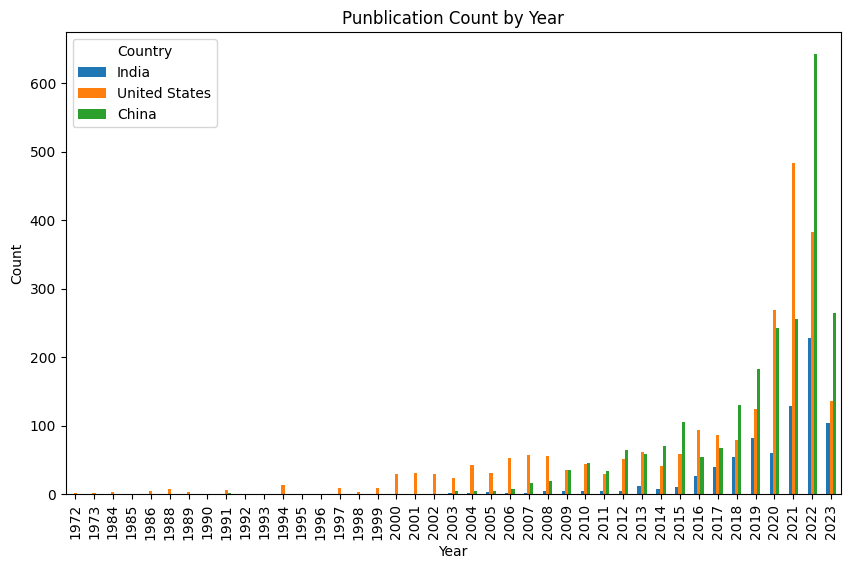

In [58]:
tmp=refine_data.groupby(['Year','Country'])['Year'].size().reset_index(name='Count')
grouped_df = tmp.groupby(['Year', 'Country']).sum().reset_index()
sorted_df = grouped_df.sort_values(['Year', 'Count'], ascending=[True, False])
pivot_df = tmp.pivot_table(index='Year', columns='Country', values='Count', aggfunc='sum').fillna(0)

pivot_df=pivot_df.loc[:,['India','United States','China']]

# Plot the data
pivot_df.plot(kind='bar', figsize=(10, 6))

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Punblication Count by Year')

# Show the plot
plt.show()

### Q11.Country wise total number of publication

In [59]:
tmp=refine_data[(refine_data['Year']>=2016) & (refine_data['Year']<=2023)]
tmp=tmp[tmp['Country'].isin(['Russia','India','China','Egypt','Germany','Malaysia'])]
country_year_table = tmp.groupby(['Country', 'Year']).agg({'Publication count': 'sum'})
pivot_table = country_year_table.pivot_table(index='Year', columns='Country', values='Publication count').fillna(0)
pivot_table

Country,China,Egypt,Germany,India,Malaysia,Russia
Year,,,,,,
2016,185.0,0.0,128.0,69.0,18.0,31.0
2017,219.0,15.0,95.0,114.0,13.0,9.0
2018,453.0,1.0,41.0,153.0,45.0,60.0
2019,645.0,35.0,483.0,200.0,11.0,9.0
2020,929.0,45.0,108.0,159.0,10.0,66.0
2021,899.0,24.0,330.0,443.0,0.0,26.0
2022,2934.0,57.0,488.0,899.0,65.0,177.0
2023,1385.0,71.0,126.0,534.0,33.0,68.0


<Figure size 1500x700 with 0 Axes>

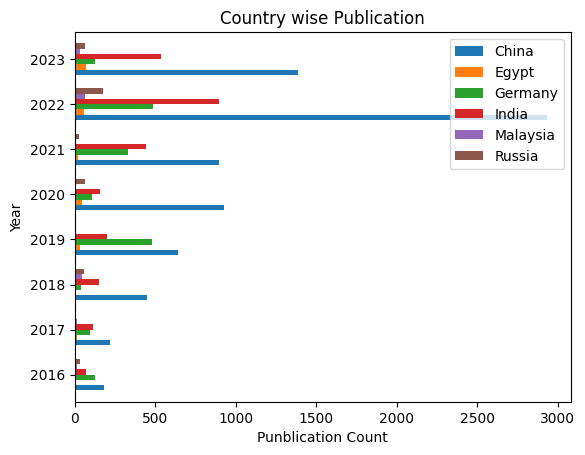

In [60]:
plt.figure(figsize=(15, 7))

# Plot the horizontal bar chart
pivot_table.plot(kind='barh', width=0.7 )

# Add labels and title
plt.xlabel('Punblication Count')
plt.ylabel('Year')
plt.title('Country wise Publication')
plt.legend(loc='upper right')

# Show plot
plt.show()


